## GENRE CLASSIFIER

In [54]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import librosa

# load data
dataset_path = "path\\to\\json"

def load_data(dataset_path):
    with open(dataset_path, "r") as fp: # r for reading
        data = json.load(fp)
    
    # convert lists into numpy array because labels and mfccs are lists
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    genres = data["mapping"]
    genre_names = [genre.split('\\')[-1] for genre in genres]
    
    return inputs, targets, genre_names

def prepare_dataset(test_size, valid_size):
    
    X, y, genres = load_data(dataset_path)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=valid_size)
    
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_valid = X_valid[..., np.newaxis]
    return X_train, y_train, X_valid, y_valid, X_test, y_test

def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label = "Train accuracy")
    axs[0].plot(history.history["val_accuracy"], label = "Test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("Accuracy eval")

    # create loss subplot
    axs[1].plot(history.history["loss"], label = "Train loss")
    axs[1].plot(history.history["val_loss"], label = "Test loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("Loss eval")

    fig.tight_layout() # creates space between subplots
    plt.savefig("history.png", dpi = 300)
    plt.show()

def preprocess_wav(file):

    signal, sr = librosa.load(file, sr=22050, duration=30)  # Ensure consistent sampling rate

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T  # Transpose to get the correct input shape

    target_length = 130
    if mfcc.shape[0] < target_length:
        # Pad with zeros if mfcc is shorter
        mfcc = np.pad(mfcc, ((0, target_length - mfcc.shape[0]), (0, 0)), mode='constant')
    else:
        # Truncate if mfcc is longer
        mfcc = mfcc[:target_length, :]
        
    return mfcc[...,np.newaxis]

def predict(model, X):
    X = X[np.newaxis,...]
    
    # Make prediction
    prediction = model.predict (X)

    # Get the predicted genre index
    genre_index = np.argmax (prediction, axis=1)[0]  # Get the index of the genre with the highest probability

    # Get the confidence (accuracy) as the probability associated with the predicted genre
    predicted_confidence = float(np.max(prediction))  # This is the maximum probability of the predicted genre

    genres = load_data(dataset_path)[-1]
    predicted_genre = genres[genre_index]
    print(f"Prediction: {predicted_genre}, Confidence: {predicted_confidence}")

In [55]:
# load data
inputs_train, targets_train, inputs_val, targets_val, inputs_test, targets_test = prepare_dataset(0.25, 0.2)

# build the network architecture with keras
overf_mp = keras.Sequential([
     
    # input layer
    keras.layers.Flatten(input_shape = (inputs_train.shape[1], inputs_train.shape[2])), # turns 2D array into a 1D array
    
    # 1st. hidden layer
    keras.layers.Dense(512, activation = "relu"), # ReLU activation function
     
     # 2nd. hidden layer
    keras.layers.Dense(256, activation = "relu"), # ReLU activation function
     
     # 3rd. hidden layer
    keras.layers.Dense(64, activation = "relu"), # ReLU activation function
     
    # output layers
    keras.layers.Dense(10, activation = "softmax") # 10 categories, softmax normalizes result to 0 - 1
])

# compile
optimizer = keras.optimizers.Adam(learning_rate = 0.0001) # Adam = variation of SGD
overf_mp.compile(optimizer = optimizer, 
              loss = "sparse_categorical_crossentropy", # loss type depends on the type of task
              metrics = ["accuracy"])

# overf_mp.summary()

"""OVERFITTING:

Can be spotted by comparing loss and accuracy of the train set and the test set."""
    
# train network / create the history variable to compare accuracy and loss
history = overf_mp.fit(inputs_train, targets_train, 
          validation_data = (inputs_test, targets_test),
         epochs = 50,
         batch_size = 32) # batch_size defines the step at which the stochastic GD is performed

# Evaluate the model on the test set
test_loss, test_accuracy = overf_mp.evaluate(inputs_test, targets_test, batch_size=32)

# Print the results
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

overf_mp.save(r"C:\Users\LEGION\PycharmProjects\MGCPyTorch\model\overf_model.keras")

Epoch 1/50


C:\Users\LEGION\PycharmProjects\DeepLearningCourse\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2462 - loss: 21.9874 - val_accuracy: 0.1942 - val_loss: 2.5322
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2437 - loss: 2.1916 - val_accuracy: 0.2887 - val_loss: 2.1374
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3444 - loss: 1.9069 - val_accuracy: 0.3100 - val_loss: 2.0434
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3854 - loss: 1.7714 - val_accuracy: 0.3376 - val_loss: 2.0779
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4048 - loss: 1.7169 - val_accuracy: 0.3124 - val_loss: 2.0282
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4484 - loss: 1.6211 - val_accuracy: 0.3184 - val_loss: 1.9919
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4375 - loss: 1.5775 - val_accuracy: 0.3508 - val_loss: 1.9570
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4656 - loss: 1.5359 - val_accuracy: 0.4081 - val

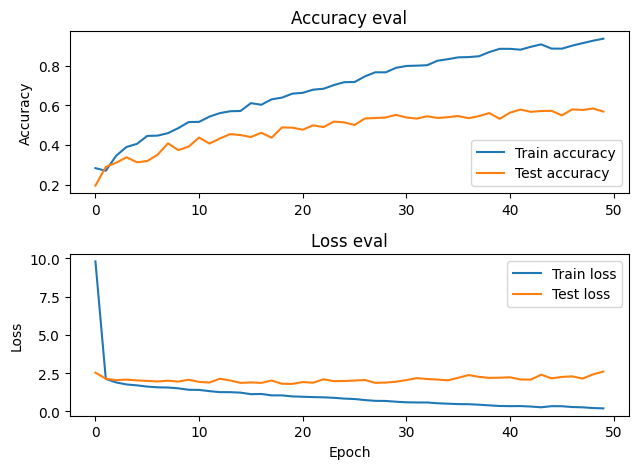

In [56]:
plot_history(history)

In [57]:
"""Implementing dropouts and regularization to solve overfitting."""
    
# load data
inputs_train, targets_train, inputs_val, targets_val, inputs_test, targets_test = prepare_dataset(0.25, 0.2)

# build the network architecture with keras
overf_solved_model = keras.Sequential([
     
    # input layer
    keras.layers.Flatten(input_shape = (inputs_train.shape[1], inputs_train.shape[2])), # turns 2D array into a 1D array
    
    # 1st. hidden layer
    keras.layers.Dense(512, activation = "relu", 
                       kernel_regularizer=keras.regularizers.L2(0.001)), 
    keras.layers.Dropout(0.3),
     
     # 2nd. hidden layer
    keras.layers.Dense(256, activation = "relu", 
                       kernel_regularizer=keras.regularizers.L2(0.001)), 
    keras.layers.Dropout(0.3),
     
     # 3rd. hidden layer
    keras.layers.Dense(64, activation = "relu", 
                       kernel_regularizer=keras.regularizers.L2(0.001)), 
    keras.layers.Dropout(0.3),
     
    # output layers
    keras.layers.Dense(10, activation = "softmax") # 10 categories, softmax normalizes result to 0 - 1
])

# compile
optimizer = keras.optimizers.Adam(learning_rate = 0.0001) # Adam = variation of SGD
overf_solved_model.compile(optimizer = optimizer, 
              loss = "sparse_categorical_crossentropy", # loss type depends on the type of task
              metrics = ["accuracy"])

# overf_solved_model.summary()

"""OVERFITTING:

Can be spotted by comparing loss and accuracy of the train set and the test set."""
    
# create the history variable to compare accuracy and loss
overf_solved_history = overf_solved_model.fit(inputs_train, targets_train, 
          validation_data = (inputs_test, targets_test),
         epochs = 50,
         batch_size = 32) # batch_size defines the step at which the stochastic GD is performed

# Evaluate the model on the test set
test_loss_nooverf, test_accuracy_nooverf = overf_solved_model.evaluate(inputs_test, targets_test, batch_size=32)

# Print the results
print(f"Test Loss (overf. solved): {test_loss_nooverf}, Test Accuracy(overf. solved): {test_accuracy_nooverf}")

overf_solved_model.save(r"C:\Users\LEGION\PycharmProjects\MGCPyTorch\model\model_overf_solved.keras")


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1355 - loss: 43.0434 - val_accuracy: 0.0745 - val_loss: 3.5045
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1254 - loss: 8.2693 - val_accuracy: 0.0801 - val_loss: 3.5065
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0961 - loss: 4.8825 - val_accuracy: 0.0881 - val_loss: 3.5035
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0937 - loss: 4.0912 - val_accuracy: 0.1081 - val_loss: 3.5055
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1180 - loss: 3.8636 - val_accuracy: 0.1093 - val_loss: 3.5032
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1176 - loss: 3.7649 - val_accuracy: 0.1213 - val_loss: 3.4871
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1225 - loss: 3.6030 - val_accuracy: 0.1306 - val_loss: 3.4715
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1243 - loss: 3.5852 - val_accuracy: 0

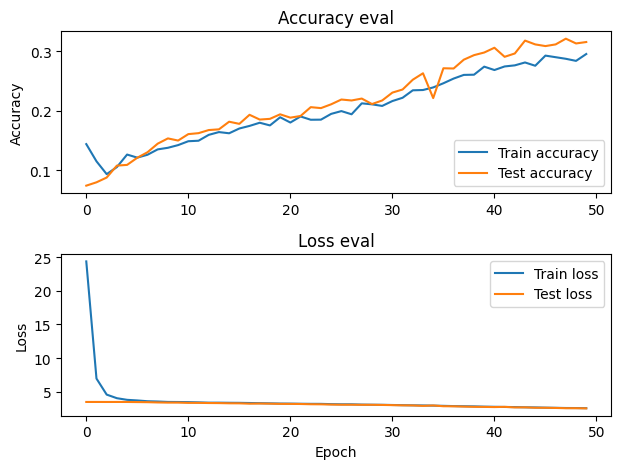

In [58]:
plot_history(overf_solved_history)

In [60]:
# CNN

X_train, y_train, X_valid, y_valid, X_test, y_test = prepare_dataset(0.25, 0.2)
input_shape = X_train.shape[1],X_train.shape[2], X_train.shape[3]

cnn = keras.Sequential()

# Convolutional Block 1
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding="same"))
cnn.add(keras.layers.BatchNormalization())

# Convolutional Block 2
cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding="same"))
cnn.add(keras.layers.BatchNormalization())

# Convolutional Block 3
cnn.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding="same"))
cnn.add(keras.layers.BatchNormalization())

# Convolutional Block 4
cnn.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding="same"))
cnn.add(keras.layers.BatchNormalization())

# Flatten and Fully Connected Layers
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(128, activation="relu"))
cnn.add(keras.layers.Dropout(0.5))  # Increased dropout for better regularization
cnn.add(keras.layers.Dense(10, activation="softmax"))  # Output layer

# model.summary()

# Compile the model
cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Assuming multi-class classification
              metrics=['accuracy'])

cnn_history = cnn.fit(X_train, y_train,
                 validation_data = (X_valid, y_valid),
                 epochs = 40,
                 batch_size = 32)

cnn.save(r"C:\Users\LEGION\PycharmProjects\MGCPyTorch\model\cnn_model.keras")

# Evaluate the model on the test set
test_error, test_accuracy = cnn.evaluate(X_test, y_test, batch_size=32, verbose = 1)
print(f'Test accuracy is: {test_accuracy}, test error is: {test_error}')

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3390 - loss: 2.1529 - val_accuracy: 0.5394 - val_loss: 1.3538
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4643 - loss: 1.5018 - val_accuracy: 0.5481 - val_loss: 1.1974
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5272 - loss: 1.3225 - val_accuracy: 0.6235 - val_loss: 1.1185
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5841 - loss: 1.1806 - val_accuracy: 0.6315 - val_loss: 1.0568
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6246 - loss: 1.0702 - val_accuracy: 0.6929 - val_loss: 0.8525
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6748 - loss: 0.9531 - val_accuracy: 0.7003 - val_loss: 0.9102
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6999 - loss: 0.8457 - val_accuracy: 0.7323 - val_loss: 0.8442
Epoch 8/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7433 - loss: 0.7558 - val_accu

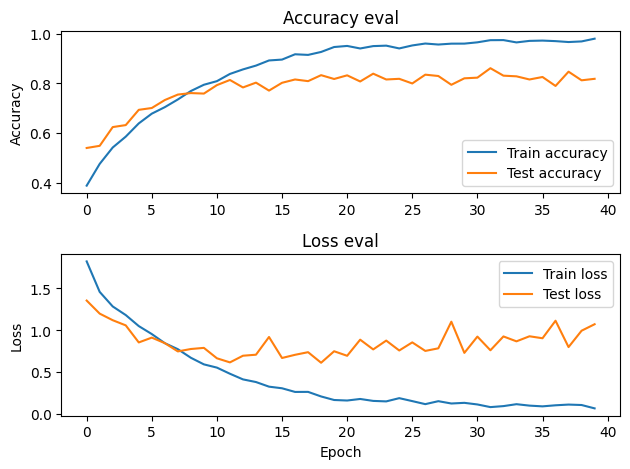

In [61]:
plot_history(cnn_history)

In [70]:
song = preprocess_wav(r"C:\Users\LEGION\PycharmProjects\DeepLearningCourse\Data\genres_original\reggae\reggae.00005.wav")
predict(overf_mp, song)
predict(overf_solved_model, song)
predict(cnn, song)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: reggae, Confidence: 0.9986512064933777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: classical, Confidence: 0.12099052220582962
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction: reggae, Confidence: 1.0
